In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt

In [4]:
def load_cv_results(models, base_dir, years=[2015, 2016, 2017], ext='', fluxes=False):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    radar_idx = dict()
    
    for i, m in enumerate(models):

        # load predictions
        model_dir = osp.join(base_dir, f'nested_cv_{m}')
        result_list = []
        radar_idx_list = []
        for fold, y in enumerate(years):
            file = osp.join(model_dir, f'test_{y}', 'final_evaluation', 'trial_1', f'results{ext}.csv')
            df = pd.read_csv(file)
            df['fold'] = fold
            result_list.append(df)
            
            radar_path = osp.join(osp.dirname(file), 'radar_index.pickle')
            if osp.isfile(radar_path):
                with open(radar_path, 'rb') as f:
                    radar_idx_list.append(pickle.load(f))
        radar_idx[m] = radar_idx_list
        results[m] = pd.concat(result_list)
        
        print(f'successfully loaded results for {m}')
        
        # load fluxes
        if fluxes and 'Flux' in m:
            m_fluxes = [dict(), dict()]
            for fold, y in enumerate(years):
                sub_dir = osp.join(model_dir, f'test_{y}', 'final_evaluation', 'trial_1')
                          
                with open(osp.join(sub_dir, f'radar_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[0][fold] = pickle.load(f)
                          
                with open(osp.join(sub_dir, f'model_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[1][fold] = pickle.load(f)
    
            all_fluxes[m] = m_fluxes

    return results, bird_scales, all_fluxes, radar_idx

In [5]:
def compute_rmse(m, results, groupby='fold', threshold=0, km2=True):
    
    ext = '_km2' if km2 else ''
        
    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}')
    rmse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean).apply(np.sqrt)
    rmse = rmse.reset_index(name='rmse')
    rmse['model'] = m
    
    return rmse

In [6]:
def plot_fluxes(voronoi, G, all_fluxes, results, fold=0, model=1, context=24, horizon=64, bird_scale=1, 
                net_fluxes=False, abm=False, ax=None, crs=None, max_flux=0):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    if abm:
        f = np.concatenate([f[..., :horizon+1] for f in all_fluxes.values()], axis=-1)
        mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes))])
    else:
        print(len(all_fluxes[fold]), results.horizon.unique())
        if model:
            f = torch.cat([f for f in all_fluxes[fold].values()], dim=-1).detach().numpy()
        else:
            f = torch.cat([f[..., context:context+horizon] for f in all_fluxes[fold].values()], dim=-1).detach().numpy()
        mask = np.concatenate([results.query(f'seqID == {i} & horizon >= {context}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[fold]))])


    #radars = results.radar.unique()
    radars = voronoi.radar.values
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask]) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask])
            #print(val)
            if net_fluxes:
                val = val - val2
            if val > 0 and i !=j :
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    max_flux = max(max_flux, fluxes.max())
    norm = plt.Normalize(0, max_flux)
    #print(fluxes.min(), fluxes.max())
    #print(nx.get_edge_attributes(G_new, 'flux'))
    edge_colors = cmap(norm(fluxes))

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    if abm:
        ax.set(title='averaged simulated fluxes between radars')
    else:
        ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, ax, max_flux

In [7]:
base_dir = '/home/fiona/birdMigration/results'

In [7]:
models = ['GAM', 'LocalMLP', 'LocalLSTM', 'FluxGraphLSTM']
ext = '_fixedT0'
all_rmse = []
all_rmse_per_h = []
for m in models:
    all_rmse.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_fold_thr0{ext}.csv')))
    all_rmse_per_h.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_hour_thr0{ext}.csv')))
df_rmse = pd.concat(all_rmse)
df_rmse_h = pd.concat(all_rmse_per_h)

In [80]:
with open(osp.join(base_dir, 'nested_cv_LocalLSTM', 'test_2016', 'final_evaluation', 'trial_1', 'attention_weights.pickle'), 'rb') as f:
    att = pickle.load(f)

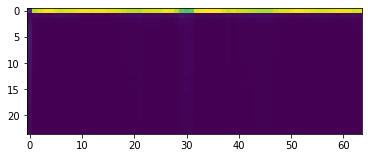

In [82]:
plt.imshow(att[4][4])

In [79]:
att[0][0].sum(0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [23]:
radar_df = gpd.read_file('/home/fiona/birdMigration/data/shapes/all_radars.shp')

In [46]:
radars = {
    'chalb': (47.2843, 8.512),
    'chwei': (46.835, 9.7945),
    'chlem': (46.0408, 8.8332),
    'chppm': (46.3706, 7.4866),
    'chdol': (46.4251, 6.0994),
    'frmtc': (47.3686, 7.019),
    'frnan': (48.7158, 6.5816),
    'frtro': (48.4621, 4.3093),
    'frave': (50.1283, 3.8118),
    'frabb': (50.136, 1.8347),
    'frtra': (48.7746, 2.0083),
    'frbla': (47.3552, 4.7759),
    'frniz': (46.0678, 4.4453),
    'frcae': (48.9272, -0.1496),
    'frpla': (48.4609, -4.4298),
    'frtre': (47.3374, -1.6563),
    'frche': (46.6986, 0.0656),
    'frbou': (47.0586, 2.3595),
    'frlep': (45.2892, 3.7095),
    'frgre': (45.1044, 1.3697),
    'frbor': (44.8315, -0.6919),
    'frmom': (43.6245, -0.6094),
    'frtou': (43.5743, 1.3763),
    'fropo': (42.9184, 2.865),
    'frmcl': (43.9905, 2.6096),
    'frnim': (43.8061, 4.5027),
    'frbol': (44.323, 4.7621)
}

lons = [v[1] for k,v in radars.items()]
lats = [v[0] for k,v in radars.items()]


In [53]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2015/voronoi.shp')
voronoi = voronoi.query('observed == True')
r = voronoi.radar.values
lon = voronoi.lon.values
lat = voronoi.lat.values

all_rads = np.concatenate((r, np.array(list(radars.keys()))))
all_lons = np.concatenate((lon, lons))
all_lats = np.concatenate((lat, lats))

df = pd.DataFrame({'radar': all_rads, 'lon': all_lons, 'lat': all_lats})

In [54]:
df

,radar,lon,lat
0,deemd,7.025000,53.339440
1,detur,9.782780,48.585280
2,denhb,6.548530,50.109730
3,deboo,10.046830,54.004400
4,deros,12.058080,54.175660
5,deisn,12.101770,48.174700
6,deess,6.966944,51.405556
7,dehnr,9.694520,52.460080
8,nldbl,5.178340,52.101681
9,demem,10.220420,48.043060


In [57]:
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
df.to_file('/home/fiona/birdMigration/data/raw/abm/all_radars.shp')

In [61]:
dict(zip(zip(df.lon, df.lat), df.radar.values))

{(7.025, 53.33944): 'deemd',
 (9.78278, 48.58528): 'detur',
 (6.54853, 50.10973): 'denhb',
 (10.046829999999998, 54.0044): 'deboo',
 (12.058079999999999, 54.17566): 'deros',
 (12.10177, 48.1747): 'deisn',
 (6.966944, 51.405556000000004): 'deess',
 (9.69452, 52.46008): 'dehnr',
 (5.178339958190918, 52.101680755615234): 'nldbl',
 (10.22042, 48.04306): 'demem',
 (12.40278, 49.540659999999995): 'deeis',
 (5.5056, 49.9143): 'bewid',
 (8.71397, 49.98592000000001): 'deoft',
 (3.0642, 51.191700000000004): 'bejab',
 (11.135040000000002, 50.50012): 'deneu',
 (8.80206, 51.31119): 'defld',
 (4.454999923706055, 50.90549850463867): 'bezav',
 (13.857810000000002, 52.64856999999999): 'depro',
 (4.799970149993897, 52.953338623046875): 'nldhl',
 (8.00386, 47.87357): 'defbg',
 (13.768640000000001, 51.12463999999999): 'dedrs',
 (11.17609, 52.16009): 'deumd',
 (8.512, 47.2843): 'chalb',
 (9.7945, 46.835): 'chwei',
 (8.8332, 46.0408): 'chlem',
 (7.4866, 46.3706): 'chppm',
 (6.0994, 46.4251): 'chdol',
 (7.01

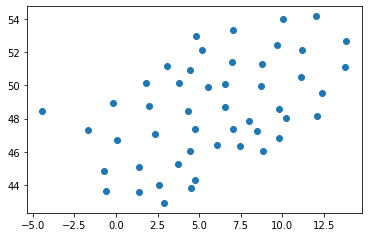

In [56]:
df.plot()

array([5.46728725e-03, 2.96552014e-05, 2.86816852e-06, 2.99790991e-06])

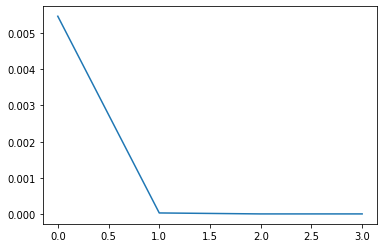

In [21]:
loss = np.load(osp.join(base_dir, 'LocalLSTM', 'test_2017', 'final_evaluation', 'test_1', 'validation_curves.npy'))
ws = 50
mean_loss = np.array([loss[0, i-ws:i].mean() for i in np.arange(ws, 300, ws)])
delta = mean_loss[:-1] - mean_loss[1:]
plt.plot(delta[:])
#plt.yscale('log')
delta

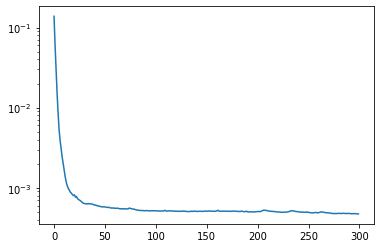

In [18]:
plt.plot(loss.mean(0))
plt.yscale('log')

fig, ax = plt.subplots(figsize=(10,4))
for m in models:
    df = df_rmse_h.query(f'model == "{m}"')  
    grouped = df.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean)
    std = grouped.rmse.aggregate(np.nanstd)
    line = ax.plot(range(avg.size), avg, label=m)
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

In [36]:
models = ['GAM', 'LocalMLP', 'LocalLSTM']#, 'FluxGraphLSTM']
ext = ''
all_rmse = []
all_rmse_per_h = []
for m in models:
    all_rmse.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_fold_thr0{ext}.csv')))
    all_rmse_per_h.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_hour_thr0{ext}.csv')))
df_rmse = pd.concat(all_rmse)
df_rmse_h = pd.concat(all_rmse_per_h)

In [37]:
df_rmse_h

,Unnamed: 0,horizon,fold,rmse,model
0,0,0,0,NaN,GAM
1,1,0,1,NaN,GAM
2,2,0,2,NaN,GAM
3,3,1,0,NaN,GAM
4,4,1,1,NaN,GAM
...,...,...,...,...,...
259,259,86,1,12.570051,LocalLSTM
260,260,86,2,10.958682,LocalLSTM
261,261,87,0,11.895884,LocalLSTM
262,262,87,1,12.628425,LocalLSTM


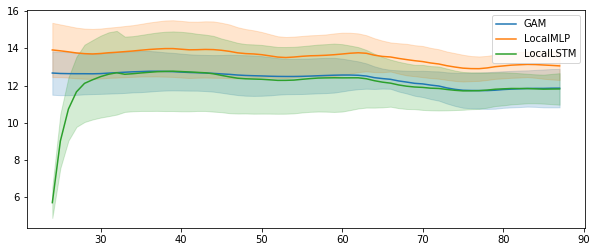

In [39]:
fig, ax = plt.subplots(figsize=(10,4))
for m in models:
    df = df_rmse_h.query(f'model == "{m}"')  
    grouped = df.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean)
    std = grouped.rmse.aggregate(np.nanstd)
    line = ax.plot(range(avg.size), avg, label=m)
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

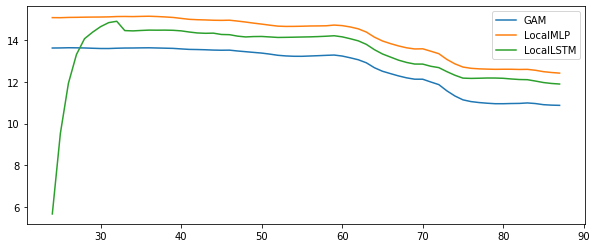

In [40]:
fig, ax = plt.subplots(figsize=(10,4))
for m in models:
    df = df_rmse_h.query(f'model == "{m}" & fold == 0')  
    grouped = df.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean)
    std = grouped.rmse.aggregate(np.nanstd)
    line = ax.plot(range(avg.size), avg, label=m)
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

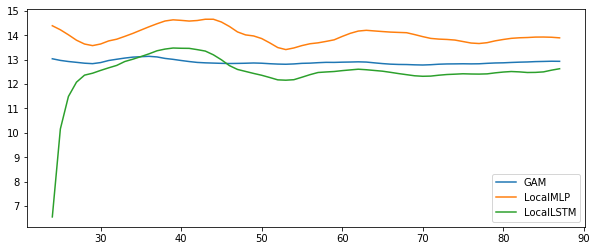

In [41]:
fig, ax = plt.subplots(figsize=(10,4))
for m in models:
    df = df_rmse_h.query(f'model == "{m}" & fold == 1')  
    grouped = df.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean)
    std = grouped.rmse.aggregate(np.nanstd)
    line = ax.plot(range(avg.size), avg, label=m)
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

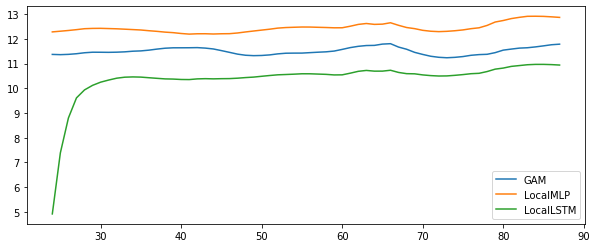

In [42]:
fig, ax = plt.subplots(figsize=(10,4))
for m in models:
    df = df_rmse_h.query(f'model == "{m}" & fold == 2')  
    grouped = df.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean)
    std = grouped.rmse.aggregate(np.nanstd)
    line = ax.plot(range(avg.size), avg, label=m)
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

In [6]:
local_models = ['GAM', 'GBT', 'LocalMLP']
models = ['LocalLSTM']
results, bird_scales, _, radar_idx = load_cv_results(local_models, base_dir)
#results2, bird_scales2, _, radar_idx2 = load_cv_results(['GBT'], base_dir)

successfully loaded results for GAM
successfully loaded results for GBT
successfully loaded results for LocalMLP


In [16]:
results3, bird_scales3, fluxes3, radar_idx3 = load_cv_results(['GAM', 'LocalMLP', 'LocalLSTM', 'FluxGraphLSTM'], base_dir, ext='_fixedT0', fluxes=True)

successfully loaded results for GAM
successfully loaded results for LocalMLP
successfully loaded results for LocalLSTM
successfully loaded results for FluxGraphLSTM


In [75]:
results4, bird_scales4, fluxes4, radar_idx4 = load_cv_results(['FluxGraphLSTM'], base_dir, years=[2015], ext='_fixedT0', fluxes=True)

successfully loaded results for FluxGraphLSTM


0.05000269261364773


[None]

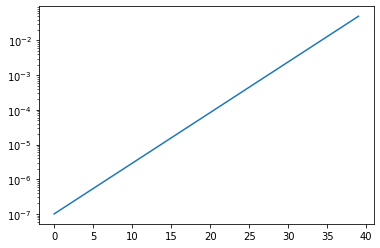

In [7]:
start = 1e-7
decay = 1.4
step = 1
lr = [start * decay**(i//step) for i in range(40)]
fig, ax = plt.subplots()
ax.plot(lr)
print(lr[-1])
ax.set(yscale='log')

In [70]:
lr[6]

2.985983999999999e-06

59 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]


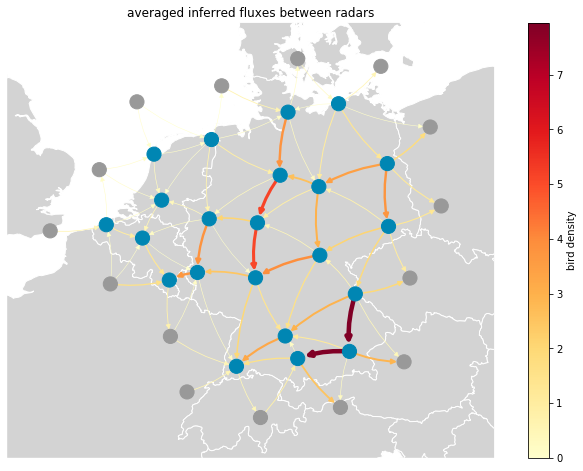

In [23]:
m = 'FluxGraphLSTM'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2017/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2017/delaunay.gpickle'
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
ax.set_extent([0, 17, 45.5, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_new, ax, max_flux = plot_fluxes(voronoi, G, fluxes3[m][0], results3[m], fold=2, 
                         model=0, bird_scale=1,
                        abm=False, ax=ax, crs=crs.proj4_init)

In [32]:
results3[m].seqID.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

59 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]


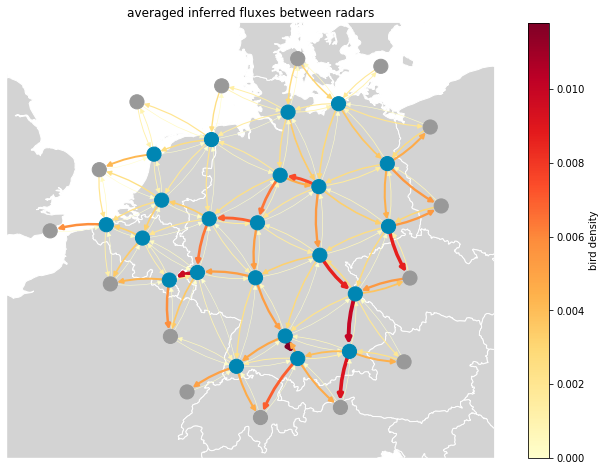

In [21]:
m = 'FluxGraphLSTM'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2017/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2017/delaunay.gpickle'
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
ax.set_extent([0, 17, 45.5, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_new, ax, max_flux = plot_fluxes(voronoi, G, fluxes3[m][1], results3[m], fold=2, 
                         model=1, bird_scale=1,
                        abm=False, ax=ax, crs=crs.proj4_init)

85 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]


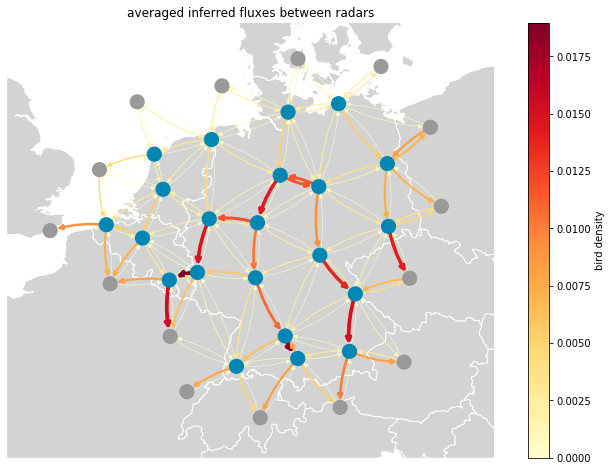

In [76]:
m = 'FluxGraphLSTM'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
ax.set_extent([0, 17, 45.5, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_new, ax, max_flux = plot_fluxes(voronoi, G, fluxes4[m][1], results4[m], fold=0, 
                         model=1, bird_scale=1,
                        abm=False, ax=ax, crs=crs.proj4_init)

In [39]:
results3['FluxGraphLSTM'].flux.max()

1.4096488e-08

In [49]:
seq4 = results3['FluxGraphLSTM'].query('seqID == 18 & radar == "deess" & fold == 2')
seq4_l = results3['LocalLSTM'].query('seqID == 18 & radar == "deess" & fold == 2')

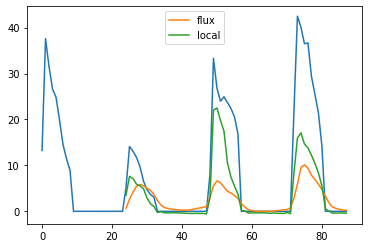

In [50]:
fig, ax = plt.subplots()
T = seq4.gt_km2.size
ax.plot(range(T), seq4.gt_km2)
ax.plot(range(T), seq4.prediction_km2, label='flux')
ax.plot(range(T), seq4_l.prediction_km2, label='local')
ax.legend()

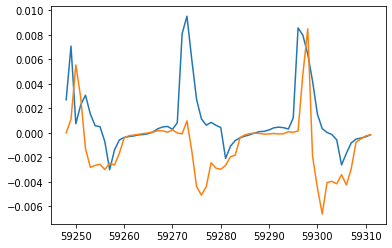

In [51]:
fig, ax = plt.subplots()
ax.plot(seq4['source/sink'])
ax.plot(seq4['flux'])

In [23]:
seq = results['LocalLSTM'].query('seqID == 34 & radar == "deess" & fold == 0')
seq2 = results2['GBT'].query('seqID == 3 & radar == "deess" & fold == 0')

In [24]:
seq

,Unnamed: 0,gt,gt_km2,prediction,prediction_km2,night,radar,seqID,tidx,datetime,horizon,missing,trial,residual,residual_km2,fold
66352,66352,1.949970,1.949970,NaN,NaN,True,deess,34,1039,2015-09-13 19:00:00+00:00,0,False,1,NaN,NaN,0
66353,66353,1.584152,1.584152,NaN,NaN,True,deess,34,1040,2015-09-13 20:00:00+00:00,1,False,1,NaN,NaN,0
66354,66354,0.077521,0.077521,NaN,NaN,True,deess,34,1041,2015-09-13 21:00:00+00:00,2,False,1,NaN,NaN,0
66355,66355,0.390804,0.390804,NaN,NaN,True,deess,34,1042,2015-09-13 22:00:00+00:00,3,False,1,NaN,NaN,0
66356,66356,0.154121,0.154121,NaN,NaN,True,deess,34,1043,2015-09-13 23:00:00+00:00,4,False,1,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66435,66435,0.000000,0.000000,0.105330,0.105330,False,deess,34,1122,2015-09-17 06:00:00+00:00,83,False,1,-0.105330,-0.105330,0
66436,66436,0.000000,0.000000,0.107934,0.107934,False,deess,34,1123,2015-09-17 07:00:00+00:00,84,False,1,-0.107934,-0.107934,0
66437,66437,0.000000,0.000000,-0.097685,-0.097685,False,deess,34,1124,2015-09-17 08:00:00+00:00,85,False,1,0.097685,0.097685,0
66438,66438,0.000000,0.000000,0.040230,0.040230,False,deess,34,1125,2015-09-17 09:00:00+00:00,86,False,1,-0.040230,-0.040230,0


In [19]:
seq2

,Unnamed: 0,gt_km2,prediction_km2,gt,prediction,night,radar,seqID,tidx,datetime,trial,horizon,missing,residual_km2,residual,fold
64416,64416,0.000000,NaN,0.00,NaN,False,deess,33,1414,2015-09-29 10:00:00+00:00,1,0,False,NaN,NaN,0
64417,64417,0.000000,NaN,0.00,NaN,False,deess,33,1415,2015-09-29 11:00:00+00:00,1,1,False,NaN,NaN,0
64418,64418,0.000000,NaN,0.00,NaN,False,deess,33,1416,2015-09-29 12:00:00+00:00,1,2,False,NaN,NaN,0
64419,64419,0.000000,NaN,0.00,NaN,False,deess,33,1417,2015-09-29 13:00:00+00:00,1,3,False,NaN,NaN,0
64420,64420,0.000000,NaN,0.00,NaN,False,deess,33,1418,2015-09-29 14:00:00+00:00,1,4,False,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64499,64499,15.011149,22.572191,353272.90,531214.714095,True,deess,33,1497,2015-10-02 21:00:00+00:00,1,83,False,-7.561041,-177941.807845,0
64500,64500,16.305977,22.484513,383745.44,529151.303488,True,deess,33,1498,2015-10-02 22:00:00+00:00,1,84,False,-6.178536,-145405.865988,0
64501,64501,16.860487,21.424652,396795.28,504208.489443,True,deess,33,1499,2015-10-02 23:00:00+00:00,1,85,False,-4.564165,-107413.208193,0
64502,64502,15.056759,15.610029,354346.28,367366.959036,True,deess,33,1500,2015-10-03 00:00:00+00:00,1,86,False,-0.553270,-13020.677786,0


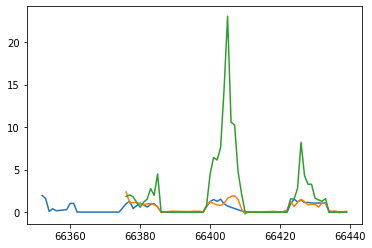

In [25]:
fig, ax = plt.subplots()
ax.plot(seq.gt_km2)
ax.plot(seq.prediction_km2)
ax.plot(seq2.prediction_km2)

In [84]:
rmse = pd.concat([compute_rmse(m, r) for m, r in results4.items()])
rmse

   fold      rmse          model
0     0  7.579569  FluxGraphLSTM


,fold,rmse,model
0,0,7.579569,FluxGraphLSTM


In [17]:
rmse = pd.concat([compute_rmse(m, r) for m, r in results3.items()])
rmse

,fold,rmse,model
0,0,9.134786,GAM
1,1,9.016236,GAM
0,0,10.214454,LocalMLP
1,1,9.404358,LocalMLP
0,0,8.973305,GBT
1,1,8.489117,GBT
0,0,7.579569,FluxGraphLSTM
1,1,7.343728,FluxGraphLSTM


In [ ]:
rmse = pd.concat([compute_rmse(m, r, groupby='horizon', threshold=0) for m, r in results.items()])

fig, ax = plt.subplots()
for m in rmse.model.unique():
    df = rmse.query(f'model == "{m}"')
    ax.plot(df.rmse, label=m)
ax.legend()

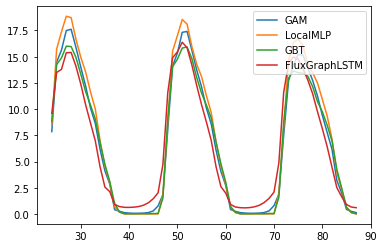

In [19]:
rmse = pd.concat([compute_rmse(m, r, groupby='horizon', threshold=0) for m, r in results3.items()])

fig, ax = plt.subplots()
for m in rmse.model.unique():
    df = rmse.query(f'model == "{m}"')
    ax.plot(df.rmse, label=m)
ax.legend()

In [12]:
rmse = pd.concat([compute_rmse(m, r, threshold=40) for m, r in results3.items()])
rmse

   fold       rmse     model
0     0  65.133440  LocalMLP
1     1  65.083618  LocalMLP
2     2  49.227252  LocalMLP
   fold       rmse      model
0     0  59.992088  LocalLSTM
1     1  58.885602  LocalLSTM
2     2  41.780986  LocalLSTM
   fold       rmse          model
0     0  60.373212  FluxGraphLSTM
1     1  55.320113  FluxGraphLSTM
2     2  40.712884  FluxGraphLSTM


,fold,rmse,model
0,0,65.133440,LocalMLP
1,1,65.083618,LocalMLP
2,2,49.227252,LocalMLP
0,0,59.992088,LocalLSTM
1,1,58.885602,LocalLSTM
2,2,41.780986,LocalLSTM
0,0,60.373212,FluxGraphLSTM
1,1,55.320113,FluxGraphLSTM
2,2,40.712884,FluxGraphLSTM


In [6]:
rmse = pd.concat([compute_rmse(m, r) for m, r in results.items()])
rmse

   fold      rmse      model
0     0  9.184107  LocalLSTM
1     1  8.175275  LocalLSTM
2     2  6.754729  LocalLSTM


,fold,rmse,model
0,0,9.184107,LocalLSTM
1,1,8.175275,LocalLSTM
2,2,6.754729,LocalLSTM


In [7]:
rmse = pd.concat([compute_rmse(m, r) for m, r in results.items()])
rmse

   fold      rmse model
0     0  8.220885   GBT
1     1  8.449771   GBT
2     2  6.847134   GBT
   fold      rmse     model
0     0  9.638630  LocalMLP
1     1  9.144690  LocalMLP
2     2  8.071226  LocalMLP


,fold,rmse,model
0,0,8.220885,GBT
1,1,8.449771,GBT
2,2,6.847134,GBT
0,0,9.638630,LocalMLP
1,1,9.144690,LocalMLP
2,2,8.071226,LocalMLP
